In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import dask
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [3]:
plt.style.use("tableau-colorblind10")

In [4]:
client = dask.distributed.Client()

In [5]:
groups = {
    "with classifier": "zc-emu-monthly-normfix-m06-seed3-30d-v1-online",
    "without classifier": "zc-emu-no-gscond-classifier-v1-online",
    "baseline": "zc-emu-monthly-normfix-m06-seed3-30d-v1-offline",
}

In [6]:
jobs = [delayed(common.open_group)(v) for v in groups.values()]
opened = Parallel(n_jobs=3)(jobs)
data = {k: ds for k, ds in zip(groups.keys(), opened)}

In [7]:
def get_day_15_cloud(ds):
    return ds["cloud_water_mixing_ratio"].isel(time=slice(8*15,8*16))

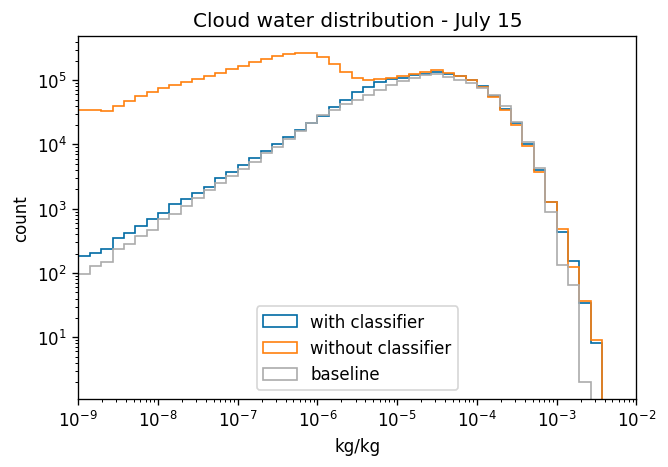

In [8]:
plt.figure(figsize=(6, 4), dpi=120)
bins = np.logspace(-9, -2, 50)
for k, v in data.items():
    get_day_15_cloud(v).plot.hist(bins=bins, histtype="step", xscale="log", yscale="log", label=k)
plt.title("Cloud water distribution - July 15")
plt.xlabel("kg/kg")
plt.ylabel("count")
plt.xlim(1e-9, 1e-2)
plt.legend(loc="lower center")
common.savefig("cloud_distribution_classification")
plt.show()

In [10]:
# mass weight this instead
no_cl_clouds = data["without classifier"]["cloud_water_mixing_ratio"]
base_clouds = data["baseline"]["cloud_water_mixing_ratio"]

In [11]:
base_mean = vcm.weighted_average(base_clouds, data["baseline"]["area"]).mean().compute()
diff = no_cl_clouds - base_clouds
bias = vcm.weighted_average(diff, data["without classifier"]["area"]).mean().compute()

In [12]:
print(f"{(bias/base_mean).values:.3f}")

0.028
